# LSTM - vanilla

In [1]:
best_model = "best_model23.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


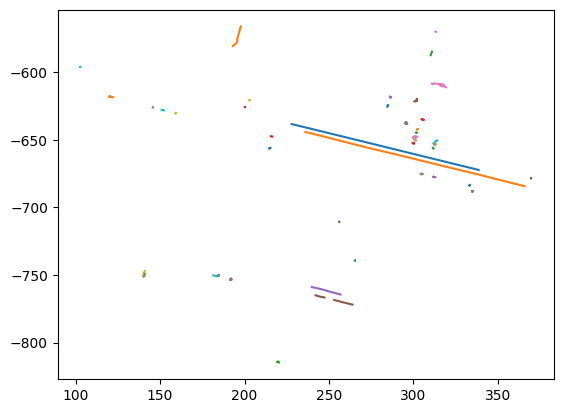

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [7]:
# class AutoRegressiveLSTM(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.future_steps = future_steps

#         # Encoder: takes in past trajectory
#         self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

#         # Decoder: predicts future positions one step at a time
#         self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
#         self.out = nn.Linear(hidden_dim, output_dim)

#     def forward(self, data, forcing_ratio = 0.5):
#     # def forward(self, data):
#         x = data.x[..., :5]  # Use position + velocity
#         x = x.reshape(-1, 50, 50, 5)[:, 0, :, :]  # (batch, 50, 5), ego only
         
#         batch_size = x.size(0)
        
#         if self.training:
#             future = data.y.view(batch_size, 60, 2) # (batch, 60, 2)

#         # Encode past
#         _, (hidden, cell) = self.encoder(x)

#         # Initialize decoder input with last observed position
#         decoder_input = x[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)
        
#         # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

#         outputs = []

#         for t in range(self.future_steps):
#             output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
#             pred = self.out(output)  # (batch, 1, 2)
#             outputs.append(pred)

#             # TODO: remove forcing ratio?
#             if self.training and random.random() < forcing_ratio:
#             # if self.training:
#                 decoder_input = future[:, t].unsqueeze(1)  # ground truth
#                 # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
#             else:
#                 decoder_input = pred.detach()  # predicted output as next input
#                 # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

#         outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
#         return outputs

In [8]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Separate encoder for ego and each neighbor agent
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # self.neighbor_encoder2 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # self.neighbor_encoder3 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder
        self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim * 2, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data, forcing_ratio=0.5):
        x = data.x[..., :5]  # Only pos & vel
        x = x.reshape(-1, 50, 50, 5)  # (batch, agents=50, time=50, features=5)
        batch_size = x.size(0)
        device = x.device

        if self.training:
            future = data.y.view(batch_size, 60, 2)

        # ---- EGO TRAJECTORY ----
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)

        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego

        # ---- SELECT 3 CLOSEST NEIGHBORS ----
        _, neighbor_ids = torch.topk(dists, k=1, dim=1, largest=False)  # (batch, 3)

        # ---- ENCODE EGO ----
        _, (ego_hidden, ego_cell) = self.encoder(ego_traj)  # each: (num_layers, batch, hidden_dim)

        # ---- ENCODE NEIGHBORS ----
        neighbor_hidden_list = []
        neighbor_cell_list = []

        for i in range(1):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b]] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            _, (n_hidden, n_cell) = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_hidden_list.append(n_hidden)
            neighbor_cell_list.append(n_cell)

        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        hidden = torch.cat([ego_hidden] + neighbor_hidden_list, dim=2)  # (num_layers, batch, hidden_dim * 4)
        cell   = torch.cat([ego_cell]   + neighbor_cell_list, dim=2)   # (num_layers, batch, hidden_dim * 4)

        # ---- DECODER INIT ----
        decoder_input = ego_traj[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            if self.training and random.random() < forcing_ratio:
                decoder_input = future[:, t].unsqueeze(1)
            else:
                decoder_input = pred.detach()

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

# Train

In [9]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                # TODO: should scale?
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE (normalized) {val_loss:.4f} | "
            f"Val MAE (true) {val_mae:.4f} | Val MSE (true) {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [10]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007,  # => 8.98, ps: 10.01
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [11]:
# closest 1 neighbor not 3
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_99590/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/150 [00:29<1:13:15, 29.50s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.0733 | Val MSE (normalized) 0.1755 | Val MAE (true) 1.9804 | Val MSE (true) 8.6010
Sample pred first 3 steps: [[-0.02281219  0.00532903]
 [-0.01371871  0.003571  ]
 [-0.00165647 -0.00037266]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.175531


Epoch:   1%|▏         | 2/150 [00:57<1:10:42, 28.66s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0041 | Val MSE (normalized) 0.4016 | Val MAE (true) 2.8381 | Val MSE (true) 19.6802


Epoch:   2%|▏         | 3/150 [01:25<1:09:53, 28.52s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0040 | Val MSE (normalized) 1.0439 | Val MAE (true) 5.3268 | Val MSE (true) 51.1517


Epoch:   3%|▎         | 4/150 [01:53<1:08:48, 28.28s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0040 | Val MSE (normalized) 0.4104 | Val MAE (true) 2.7449 | Val MSE (true) 20.1072


Epoch:   3%|▎         | 5/150 [02:21<1:07:50, 28.07s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0040 | Val MSE (normalized) 0.1126 | Val MAE (true) 1.5961 | Val MSE (true) 5.5165
Validation improved: 0.175531 -> 0.112581


Epoch:   4%|▍         | 6/150 [02:49<1:07:30, 28.13s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0360 | Val MSE (normalized) 0.1832 | Val MAE (true) 2.2387 | Val MSE (true) 8.9762
Sample pred first 3 steps: [[-0.21203573 -0.12548392]
 [-0.22041957 -0.11542933]
 [-0.22188875 -0.10979697]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   5%|▍         | 7/150 [03:18<1:07:08, 28.17s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0048 | Val MSE (normalized) 0.1123 | Val MAE (true) 1.6247 | Val MSE (true) 5.5037
Validation improved: 0.112581 -> 0.112319


Epoch:   5%|▌         | 8/150 [03:46<1:06:50, 28.25s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0042 | Val MSE (normalized) 0.0933 | Val MAE (true) 1.5396 | Val MSE (true) 4.5724
Validation improved: 0.112319 -> 0.093313


Epoch:   6%|▌         | 9/150 [04:14<1:06:32, 28.31s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0040 | Val MSE (normalized) 0.1228 | Val MAE (true) 1.6212 | Val MSE (true) 6.0191


Epoch:   7%|▋         | 10/150 [04:42<1:05:48, 28.20s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0035 | Val MSE (normalized) 0.2840 | Val MAE (true) 2.7364 | Val MSE (true) 13.9176


Epoch:   7%|▋         | 11/150 [05:10<1:04:41, 27.92s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0026 | Val MSE (normalized) 0.2191 | Val MAE (true) 2.2871 | Val MSE (true) 10.7344
Sample pred first 3 steps: [[0.03396042 0.03326222]
 [0.04123395 0.03001756]
 [0.0339615  0.03155021]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [05:39<1:05:01, 28.27s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0024 | Val MSE (normalized) 0.7776 | Val MAE (true) 4.7727 | Val MSE (true) 38.1010


Epoch:   9%|▊         | 13/150 [06:06<1:04:06, 28.08s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0022 | Val MSE (normalized) 0.2743 | Val MAE (true) 2.3973 | Val MSE (true) 13.4411


Epoch:   9%|▉         | 14/150 [06:34<1:03:32, 28.04s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0021 | Val MSE (normalized) 0.0981 | Val MAE (true) 1.4832 | Val MSE (true) 4.8071


Epoch:  10%|█         | 15/150 [07:02<1:02:46, 27.90s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0022 | Val MSE (normalized) 0.1021 | Val MAE (true) 1.4699 | Val MSE (true) 5.0037


Epoch:  11%|█         | 16/150 [07:31<1:03:02, 28.23s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0020 | Val MSE (normalized) 0.6403 | Val MAE (true) 3.8731 | Val MSE (true) 31.3749
Sample pred first 3 steps: [[-0.0366898   0.00874915]
 [-0.02773838  0.01670848]
 [-0.01533841  0.03487716]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  11%|█▏        | 17/150 [08:00<1:03:11, 28.51s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0021 | Val MSE (normalized) 0.1288 | Val MAE (true) 1.6619 | Val MSE (true) 6.3097


Epoch:  12%|█▏        | 18/150 [08:29<1:03:14, 28.74s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0020 | Val MSE (normalized) 0.1215 | Val MAE (true) 1.6142 | Val MSE (true) 5.9556


Epoch:  13%|█▎        | 19/150 [08:57<1:02:14, 28.50s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0020 | Val MSE (normalized) 0.1580 | Val MAE (true) 1.8911 | Val MSE (true) 7.7430


Epoch:  13%|█▎        | 20/150 [09:26<1:02:08, 28.68s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0020 | Val MSE (normalized) 0.2589 | Val MAE (true) 2.6133 | Val MSE (true) 12.6849


Epoch:  14%|█▍        | 21/150 [09:56<1:02:21, 29.00s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0021 | Val MSE (normalized) 0.4376 | Val MAE (true) 3.4430 | Val MSE (true) 21.4448
Sample pred first 3 steps: [[0.01448789 0.03393508]
 [0.02642855 0.03064401]
 [0.03913999 0.02273187]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  15%|█▍        | 22/150 [10:25<1:02:02, 29.08s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0019 | Val MSE (normalized) 0.6621 | Val MAE (true) 3.9984 | Val MSE (true) 32.4443


Epoch:  15%|█▌        | 23/150 [10:53<1:00:23, 28.53s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0021 | Val MSE (normalized) 0.3879 | Val MAE (true) 2.9162 | Val MSE (true) 19.0085


Epoch:  16%|█▌        | 24/150 [11:21<59:54, 28.52s/epoch]  

Epoch 023 | LR 0.001460 | Train MSE 0.0022 | Val MSE (normalized) 0.0892 | Val MAE (true) 1.4101 | Val MSE (true) 4.3717
Validation improved: 0.093313 -> 0.089218


Epoch:  17%|█▋        | 25/150 [11:50<59:28, 28.55s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0020 | Val MSE (normalized) 0.3159 | Val MAE (true) 2.8489 | Val MSE (true) 15.4775


Epoch:  17%|█▋        | 26/150 [12:18<59:02, 28.57s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0020 | Val MSE (normalized) 0.1758 | Val MAE (true) 2.0053 | Val MSE (true) 8.6148
Sample pred first 3 steps: [[ 0.00022808 -0.0125886 ]
 [-0.0083388  -0.02298066]
 [-0.01085678 -0.03139948]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  18%|█▊        | 27/150 [12:47<58:48, 28.69s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0021 | Val MSE (normalized) 0.0947 | Val MAE (true) 1.4593 | Val MSE (true) 4.6406


Epoch:  19%|█▊        | 28/150 [13:15<58:00, 28.53s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0023 | Val MSE (normalized) 0.2478 | Val MAE (true) 2.5051 | Val MSE (true) 12.1411


Epoch:  19%|█▉        | 29/150 [13:45<57:57, 28.74s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0023 | Val MSE (normalized) 0.0910 | Val MAE (true) 1.4622 | Val MSE (true) 4.4594


Epoch:  20%|██        | 30/150 [14:13<57:16, 28.64s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0021 | Val MSE (normalized) 0.2007 | Val MAE (true) 2.1519 | Val MSE (true) 9.8337


Epoch:  21%|██        | 31/150 [14:43<57:41, 29.09s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0022 | Val MSE (normalized) 0.0744 | Val MAE (true) 1.2472 | Val MSE (true) 3.6452
Sample pred first 3 steps: [[0.02248871 0.02067634]
 [0.02266704 0.01340483]
 [0.01704846 0.01995561]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.089218 -> 0.074392


Epoch:  21%|██▏       | 32/150 [15:13<57:37, 29.30s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0027 | Val MSE (normalized) 0.1495 | Val MAE (true) 1.7773 | Val MSE (true) 7.3252


Epoch:  22%|██▏       | 33/150 [15:43<57:13, 29.35s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0023 | Val MSE (normalized) 0.1070 | Val MAE (true) 1.5307 | Val MSE (true) 5.2423


Epoch:  23%|██▎       | 34/150 [16:11<56:03, 29.00s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0024 | Val MSE (normalized) 0.1188 | Val MAE (true) 1.6713 | Val MSE (true) 5.8225


Epoch:  23%|██▎       | 35/150 [16:39<55:09, 28.78s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0029 | Val MSE (normalized) 0.1889 | Val MAE (true) 2.1158 | Val MSE (true) 9.2574


Epoch:  24%|██▍       | 36/150 [17:06<53:47, 28.31s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0032 | Val MSE (normalized) 0.1006 | Val MAE (true) 1.5333 | Val MSE (true) 4.9298
Sample pred first 3 steps: [[ 0.00583795 -0.00879774]
 [ 0.00835568 -0.00320637]
 [ 0.00550868 -0.00614661]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [17:34<53:01, 28.15s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0026 | Val MSE (normalized) 0.2026 | Val MAE (true) 2.0116 | Val MSE (true) 9.9267


Epoch:  25%|██▌       | 38/150 [18:01<52:05, 27.91s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0028 | Val MSE (normalized) 0.0521 | Val MAE (true) 0.9613 | Val MSE (true) 2.5539
Validation improved: 0.074392 -> 0.052121


Epoch:  26%|██▌       | 39/150 [18:29<51:34, 27.88s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0032 | Val MSE (normalized) 0.1961 | Val MAE (true) 2.2379 | Val MSE (true) 9.6082


Epoch:  27%|██▋       | 40/150 [18:57<50:55, 27.78s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0038 | Val MSE (normalized) 0.0890 | Val MAE (true) 1.4337 | Val MSE (true) 4.3624


Epoch:  27%|██▋       | 41/150 [19:24<50:27, 27.78s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0033 | Val MSE (normalized) 0.0952 | Val MAE (true) 1.5081 | Val MSE (true) 4.6666
Sample pred first 3 steps: [[0.00532233 0.00613956]
 [0.01068797 0.00187729]
 [0.01608642 0.00481224]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  28%|██▊       | 42/150 [19:53<50:10, 27.87s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0060 | Val MSE (normalized) 0.0839 | Val MAE (true) 1.3036 | Val MSE (true) 4.1097


Epoch:  29%|██▊       | 43/150 [20:20<49:25, 27.72s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0044 | Val MSE (normalized) 0.1604 | Val MAE (true) 1.8791 | Val MSE (true) 7.8607


Epoch:  29%|██▉       | 44/150 [20:48<49:03, 27.77s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0115 | Val MSE (normalized) 0.0779 | Val MAE (true) 1.3178 | Val MSE (true) 3.8195


Epoch:  30%|███       | 45/150 [21:15<48:20, 27.62s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0068 | Val MSE (normalized) 0.0947 | Val MAE (true) 1.3654 | Val MSE (true) 4.6390


Epoch:  31%|███       | 46/150 [21:43<47:54, 27.64s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0181 | Val MSE (normalized) 0.0618 | Val MAE (true) 1.0797 | Val MSE (true) 3.0264
Sample pred first 3 steps: [[ 0.00961442 -0.00217176]
 [ 0.0129535   0.0009498 ]
 [ 0.0128065   0.00703873]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [22:12<48:02, 27.98s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0132 | Val MSE (normalized) 0.0753 | Val MAE (true) 1.2220 | Val MSE (true) 3.6880


Epoch:  32%|███▏      | 48/150 [22:42<48:40, 28.63s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0241 | Val MSE (normalized) 0.0959 | Val MAE (true) 1.4540 | Val MSE (true) 4.7012


Epoch:  33%|███▎      | 49/150 [23:09<47:37, 28.29s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0308 | Val MSE (normalized) 0.0728 | Val MAE (true) 1.2107 | Val MSE (true) 3.5669


Epoch:  33%|███▎      | 50/150 [23:37<46:51, 28.11s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0454 | Val MSE (normalized) 0.0530 | Val MAE (true) 0.9095 | Val MSE (true) 2.5959


Epoch:  34%|███▍      | 51/150 [24:04<46:04, 27.93s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0614 | Val MSE (normalized) 0.0582 | Val MAE (true) 1.0868 | Val MSE (true) 2.8500
Sample pred first 3 steps: [[0.01282464 0.01711261]
 [0.00871079 0.02439272]
 [0.01141141 0.02706172]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  35%|███▍      | 52/150 [24:32<45:27, 27.83s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0588 | Val MSE (normalized) 0.0557 | Val MAE (true) 0.9991 | Val MSE (true) 2.7314


Epoch:  35%|███▌      | 53/150 [25:00<44:54, 27.78s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0536 | Val MSE (normalized) 0.0481 | Val MAE (true) 0.8863 | Val MSE (true) 2.3561
Validation improved: 0.052121 -> 0.048083


Epoch:  36%|███▌      | 54/150 [25:27<44:28, 27.80s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0528 | Val MSE (normalized) 0.0554 | Val MAE (true) 1.0924 | Val MSE (true) 2.7158


Epoch:  37%|███▋      | 55/150 [25:56<44:19, 28.00s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0500 | Val MSE (normalized) 0.0502 | Val MAE (true) 0.9769 | Val MSE (true) 2.4592


Epoch:  37%|███▋      | 56/150 [26:28<46:00, 29.37s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0484 | Val MSE (normalized) 0.0445 | Val MAE (true) 0.8759 | Val MSE (true) 2.1801
Sample pred first 3 steps: [[-0.00271113 -0.03608289]
 [ 0.00406322 -0.04721684]
 [ 0.0036332  -0.04800595]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.048083 -> 0.044491


Epoch:  38%|███▊      | 57/150 [27:04<48:12, 31.10s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0480 | Val MSE (normalized) 0.0482 | Val MAE (true) 0.9475 | Val MSE (true) 2.3642


Epoch:  39%|███▊      | 58/150 [27:37<48:55, 31.91s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0463 | Val MSE (normalized) 0.0410 | Val MAE (true) 0.8019 | Val MSE (true) 2.0088
Validation improved: 0.044491 -> 0.040996


Epoch:  39%|███▉      | 59/150 [28:12<49:27, 32.61s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0463 | Val MSE (normalized) 0.0444 | Val MAE (true) 0.8742 | Val MSE (true) 2.1740


Epoch:  40%|████      | 60/150 [28:46<49:42, 33.14s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0459 | Val MSE (normalized) 0.0422 | Val MAE (true) 0.8183 | Val MSE (true) 2.0680


Epoch:  41%|████      | 61/150 [29:21<49:47, 33.57s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0449 | Val MSE (normalized) 0.0410 | Val MAE (true) 0.7958 | Val MSE (true) 2.0101
Sample pred first 3 steps: [[-0.00533427  0.0097316 ]
 [-0.00934868  0.01212978]
 [-0.0133912   0.01471621]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████▏     | 62/150 [29:55<49:47, 33.95s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0447 | Val MSE (normalized) 0.0404 | Val MAE (true) 0.8004 | Val MSE (true) 1.9802
Validation improved: 0.040996 -> 0.040411


Epoch:  42%|████▏     | 63/150 [30:30<49:33, 34.18s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0446 | Val MSE (normalized) 0.0438 | Val MAE (true) 0.8849 | Val MSE (true) 2.1452


Epoch:  43%|████▎     | 64/150 [31:05<49:27, 34.50s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0440 | Val MSE (normalized) 0.0414 | Val MAE (true) 0.8348 | Val MSE (true) 2.0262


Epoch:  43%|████▎     | 65/150 [31:42<49:43, 35.10s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0432 | Val MSE (normalized) 0.0411 | Val MAE (true) 0.8384 | Val MSE (true) 2.0116


Epoch:  44%|████▍     | 66/150 [32:15<48:15, 34.48s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0431 | Val MSE (normalized) 0.0412 | Val MAE (true) 0.8289 | Val MSE (true) 2.0201
Sample pred first 3 steps: [[-0.02048032 -0.01226503]
 [-0.02549942 -0.01480421]
 [-0.02886111 -0.01401773]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  45%|████▍     | 67/150 [32:49<47:26, 34.29s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0427 | Val MSE (normalized) 0.0396 | Val MAE (true) 0.7570 | Val MSE (true) 1.9424
Validation improved: 0.040411 -> 0.039642


Epoch:  45%|████▌     | 68/150 [33:24<47:10, 34.52s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0426 | Val MSE (normalized) 0.0406 | Val MAE (true) 0.8049 | Val MSE (true) 1.9912


Epoch:  46%|████▌     | 69/150 [33:57<46:09, 34.20s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0417 | Val MSE (normalized) 0.0405 | Val MAE (true) 0.8283 | Val MSE (true) 1.9865


Epoch:  47%|████▋     | 70/150 [34:30<44:56, 33.71s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0418 | Val MSE (normalized) 0.0412 | Val MAE (true) 0.8504 | Val MSE (true) 2.0178


Epoch:  47%|████▋     | 71/150 [35:02<43:34, 33.09s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0419 | Val MSE (normalized) 0.0407 | Val MAE (true) 0.8431 | Val MSE (true) 1.9943
Sample pred first 3 steps: [[ 0.00758889  0.01079812]
 [ 0.0019186   0.01455997]
 [-0.00405942  0.01897155]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  48%|████▊     | 72/150 [35:35<43:18, 33.31s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0415 | Val MSE (normalized) 0.0384 | Val MAE (true) 0.7545 | Val MSE (true) 1.8793
Validation improved: 0.039642 -> 0.038353


Epoch:  49%|████▊     | 73/150 [36:10<43:15, 33.70s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0416 | Val MSE (normalized) 0.0393 | Val MAE (true) 0.7922 | Val MSE (true) 1.9242


Epoch:  49%|████▉     | 74/150 [36:43<42:18, 33.40s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0410 | Val MSE (normalized) 0.0396 | Val MAE (true) 0.8181 | Val MSE (true) 1.9398


Epoch:  50%|█████     | 75/150 [37:15<41:31, 33.22s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0410 | Val MSE (normalized) 0.0407 | Val MAE (true) 0.8391 | Val MSE (true) 1.9935


Epoch:  51%|█████     | 76/150 [37:48<40:41, 33.00s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0414 | Val MSE (normalized) 0.0385 | Val MAE (true) 0.7749 | Val MSE (true) 1.8885
Sample pred first 3 steps: [[ 0.00188205 -0.00619928]
 [ 0.00083    -0.005347  ]
 [ 0.00344983 -0.00679486]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  51%|█████▏    | 77/150 [38:21<40:01, 32.89s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0409 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7455 | Val MSE (true) 1.8602
Validation improved: 0.038353 -> 0.037963


Epoch:  52%|█████▏    | 78/150 [38:53<39:16, 32.73s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0404 | Val MSE (normalized) 0.0400 | Val MAE (true) 0.8302 | Val MSE (true) 1.9614


Epoch:  53%|█████▎    | 79/150 [39:26<38:47, 32.79s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0403 | Val MSE (normalized) 0.0383 | Val MAE (true) 0.7508 | Val MSE (true) 1.8772


Epoch:  53%|█████▎    | 80/150 [39:58<38:05, 32.65s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0405 | Val MSE (normalized) 0.0382 | Val MAE (true) 0.7499 | Val MSE (true) 1.8717


Epoch:  54%|█████▍    | 81/150 [40:32<37:49, 32.90s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0403 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7556 | Val MSE (true) 1.8677
Sample pred first 3 steps: [[ 0.00272113  0.00212849]
 [-0.00140819  0.00067968]
 [-0.00239319  0.00282134]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [41:05<37:24, 33.01s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0396 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7428 | Val MSE (true) 1.8490
Validation improved: 0.037963 -> 0.037734


Epoch:  55%|█████▌    | 83/150 [41:38<37:00, 33.14s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0400 | Val MSE (normalized) 0.0378 | Val MAE (true) 0.7493 | Val MSE (true) 1.8513


Epoch:  56%|█████▌    | 84/150 [42:13<36:46, 33.44s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0397 | Val MSE (normalized) 0.0383 | Val MAE (true) 0.7694 | Val MSE (true) 1.8778


Epoch:  57%|█████▋    | 85/150 [42:47<36:28, 33.67s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0397 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7566 | Val MSE (true) 1.8625


Epoch:  57%|█████▋    | 86/150 [43:19<35:35, 33.36s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0397 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7595 | Val MSE (true) 1.8598
Sample pred first 3 steps: [[-0.00392634 -0.00872676]
 [-0.00918092 -0.00806653]
 [-0.0098181  -0.00771053]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [43:53<34:57, 33.30s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0396 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7501 | Val MSE (true) 1.8346
Validation improved: 0.037734 -> 0.037442


Epoch:  59%|█████▊    | 88/150 [44:25<34:06, 33.00s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0397 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7463 | Val MSE (true) 1.8383


Epoch:  59%|█████▉    | 89/150 [44:54<32:28, 31.95s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0393 | Val MSE (normalized) 0.0388 | Val MAE (true) 0.7787 | Val MSE (true) 1.8992


Epoch:  60%|██████    | 90/150 [45:23<30:51, 30.86s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0392 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7409 | Val MSE (true) 1.8228
Validation improved: 0.037442 -> 0.037200


Epoch:  61%|██████    | 91/150 [45:52<29:46, 30.28s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0392 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7329 | Val MSE (true) 1.8125
Sample pred first 3 steps: [[0.00227911 0.00251922]
 [0.00130009 0.00650038]
 [0.00284601 0.00829089]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.037200 -> 0.036989


Epoch:  61%|██████▏   | 92/150 [46:19<28:31, 29.51s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0392 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7408 | Val MSE (true) 1.8316


Epoch:  62%|██████▏   | 93/150 [46:47<27:30, 28.95s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0391 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7701 | Val MSE (true) 1.8590


Epoch:  63%|██████▎   | 94/150 [47:14<26:27, 28.35s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0393 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7595 | Val MSE (true) 1.8475


Epoch:  63%|██████▎   | 95/150 [47:41<25:39, 27.99s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0392 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7490 | Val MSE (true) 1.8339


Epoch:  64%|██████▍   | 96/150 [48:09<25:04, 27.85s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0389 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7455 | Val MSE (true) 1.8294
Sample pred first 3 steps: [[ 0.00297495  0.00147374]
 [ 0.00022474  0.00502054]
 [-0.00039883  0.00761702]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  65%|██████▍   | 97/150 [48:38<24:53, 28.18s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0391 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7312 | Val MSE (true) 1.8133


Epoch:  65%|██████▌   | 98/150 [49:06<24:25, 28.18s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0388 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7241 | Val MSE (true) 1.8017
Validation improved: 0.036989 -> 0.036770


Epoch:  66%|██████▌   | 99/150 [49:35<24:10, 28.44s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0387 | Val MSE (normalized) 0.0369 | Val MAE (true) 0.7285 | Val MSE (true) 1.8076


Epoch:  67%|██████▋   | 100/150 [50:04<23:48, 28.56s/epoch]

Epoch 099 | LR 0.000030 | Train MSE 0.0388 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7578 | Val MSE (true) 1.8402


Epoch:  67%|██████▋   | 101/150 [50:32<23:24, 28.67s/epoch]

Epoch 100 | LR 0.000028 | Train MSE 0.0389 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7502 | Val MSE (true) 1.8332
Sample pred first 3 steps: [[-0.00066077 -0.00089195]
 [-0.00213556  0.00181964]
 [-0.00315096  0.00382325]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [51:00<22:45, 28.45s/epoch]

Epoch 101 | LR 0.000027 | Train MSE 0.0387 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7441 | Val MSE (true) 1.8213


Epoch:  69%|██████▊   | 103/150 [51:30<22:26, 28.64s/epoch]

Epoch 102 | LR 0.000025 | Train MSE 0.0386 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7516 | Val MSE (true) 1.8223


Epoch:  69%|██████▉   | 104/150 [52:00<22:26, 29.28s/epoch]

Epoch 103 | LR 0.000024 | Train MSE 0.0387 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7279 | Val MSE (true) 1.8041


Epoch:  70%|███████   | 105/150 [52:36<23:24, 31.21s/epoch]

Epoch 104 | LR 0.000023 | Train MSE 0.0387 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7533 | Val MSE (true) 1.8298


Epoch:  71%|███████   | 106/150 [53:10<23:33, 32.12s/epoch]

Epoch 105 | LR 0.000022 | Train MSE 0.0384 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7292 | Val MSE (true) 1.8109
Sample pred first 3 steps: [[-0.00087212 -0.00071221]
 [-0.00252446  0.00049068]
 [-0.00199954  0.0001014 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  71%|███████▏  | 107/150 [53:45<23:34, 32.90s/epoch]

Epoch 106 | LR 0.000021 | Train MSE 0.0385 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7198 | Val MSE (true) 1.7949
Validation improved: 0.036770 -> 0.036632


Epoch:  72%|███████▏  | 108/150 [54:19<23:13, 33.18s/epoch]

Epoch 107 | LR 0.000020 | Train MSE 0.0387 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7476 | Val MSE (true) 1.8252


Epoch:  73%|███████▎  | 109/150 [54:53<22:54, 33.53s/epoch]

Epoch 108 | LR 0.000019 | Train MSE 0.0384 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7743 | Val MSE (true) 1.8470


Epoch:  73%|███████▎  | 110/150 [55:28<22:31, 33.79s/epoch]

Epoch 109 | LR 0.000018 | Train MSE 0.0385 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7270 | Val MSE (true) 1.8044


Epoch:  74%|███████▍  | 111/150 [56:02<22:04, 33.96s/epoch]

Epoch 110 | LR 0.000017 | Train MSE 0.0383 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7303 | Val MSE (true) 1.8035
Sample pred first 3 steps: [[ 0.00014737  0.00092978]
 [-0.0007458   0.00298679]
 [ 0.00136559  0.00434751]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  75%|███████▍  | 112/150 [56:36<21:33, 34.05s/epoch]

Epoch 111 | LR 0.000016 | Train MSE 0.0383 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7306 | Val MSE (true) 1.8047


Epoch:  75%|███████▌  | 113/150 [57:09<20:49, 33.76s/epoch]

Epoch 112 | LR 0.000015 | Train MSE 0.0384 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7330 | Val MSE (true) 1.8032


Epoch:  76%|███████▌  | 114/150 [57:44<20:21, 33.92s/epoch]

Epoch 113 | LR 0.000014 | Train MSE 0.0384 | Val MSE (normalized) 0.0365 | Val MAE (true) 0.7199 | Val MSE (true) 1.7899
Validation improved: 0.036632 -> 0.036528


Epoch:  77%|███████▋  | 115/150 [58:18<19:54, 34.13s/epoch]

Epoch 114 | LR 0.000014 | Train MSE 0.0385 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7284 | Val MSE (true) 1.8003


Epoch:  77%|███████▋  | 116/150 [58:52<19:17, 34.03s/epoch]

Epoch 115 | LR 0.000013 | Train MSE 0.0385 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7216 | Val MSE (true) 1.7941
Sample pred first 3 steps: [[0.00228163 0.00314437]
 [0.0015779  0.00520415]
 [0.00374852 0.00552875]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  78%|███████▊  | 117/150 [59:26<18:42, 34.03s/epoch]

Epoch 116 | LR 0.000012 | Train MSE 0.0383 | Val MSE (normalized) 0.0365 | Val MAE (true) 0.7214 | Val MSE (true) 1.7887
Validation improved: 0.036528 -> 0.036505


Epoch:  79%|███████▊  | 118/150 [59:59<17:57, 33.68s/epoch]

Epoch 117 | LR 0.000012 | Train MSE 0.0384 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7534 | Val MSE (true) 1.8222


Epoch:  79%|███████▉  | 119/150 [1:00:32<17:20, 33.55s/epoch]

Epoch 118 | LR 0.000011 | Train MSE 0.0384 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7191 | Val MSE (true) 1.7927


Epoch:  80%|████████  | 120/150 [1:01:05<16:40, 33.34s/epoch]

Epoch 119 | LR 0.000011 | Train MSE 0.0383 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7271 | Val MSE (true) 1.7951


Epoch:  81%|████████  | 121/150 [1:01:41<16:28, 34.09s/epoch]

Epoch 120 | LR 0.000010 | Train MSE 0.0383 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7228 | Val MSE (true) 1.7967
Sample pred first 3 steps: [[ 0.00276877 -0.00012735]
 [ 0.00253712  0.00149249]
 [ 0.00450233  0.001662  ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  81%|████████▏ | 122/150 [1:02:15<15:55, 34.13s/epoch]

Epoch 121 | LR 0.000010 | Train MSE 0.0382 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7244 | Val MSE (true) 1.7968


Epoch:  82%|████████▏ | 123/150 [1:02:48<15:08, 33.66s/epoch]

Epoch 122 | LR 0.000009 | Train MSE 0.0382 | Val MSE (normalized) 0.0369 | Val MAE (true) 0.7357 | Val MSE (true) 1.8092


Epoch:  83%|████████▎ | 124/150 [1:03:19<14:20, 33.09s/epoch]

Epoch 123 | LR 0.000009 | Train MSE 0.0383 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7286 | Val MSE (true) 1.7996


Epoch:  83%|████████▎ | 125/150 [1:03:51<13:38, 32.73s/epoch]

Epoch 124 | LR 0.000008 | Train MSE 0.0382 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7250 | Val MSE (true) 1.7972


Epoch:  84%|████████▍ | 126/150 [1:04:25<13:12, 33.03s/epoch]

Epoch 125 | LR 0.000008 | Train MSE 0.0384 | Val MSE (normalized) 0.0365 | Val MAE (true) 0.7199 | Val MSE (true) 1.7909
Sample pred first 3 steps: [[0.0009917  0.00082538]
 [0.00017893 0.00141023]
 [0.00138348 0.00171825]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  85%|████████▍ | 127/150 [1:05:00<12:50, 33.52s/epoch]

Epoch 126 | LR 0.000007 | Train MSE 0.0383 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7237 | Val MSE (true) 1.7988


Epoch:  85%|████████▌ | 128/150 [1:05:34<12:22, 33.74s/epoch]

Epoch 127 | LR 0.000007 | Train MSE 0.0379 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7272 | Val MSE (true) 1.8001


Epoch:  86%|████████▌ | 129/150 [1:06:08<11:53, 33.96s/epoch]

Epoch 128 | LR 0.000007 | Train MSE 0.0383 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7192 | Val MSE (true) 1.7926


Epoch:  87%|████████▋ | 130/150 [1:06:43<11:20, 34.04s/epoch]

Epoch 129 | LR 0.000006 | Train MSE 0.0383 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7264 | Val MSE (true) 1.7984


Epoch:  87%|████████▋ | 131/150 [1:07:17<10:50, 34.23s/epoch]

Epoch 130 | LR 0.000006 | Train MSE 0.0379 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7215 | Val MSE (true) 1.7966
Sample pred first 3 steps: [[0.00120933 0.00024201]
 [0.00055698 0.00169439]
 [0.00134251 0.00196059]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  88%|████████▊ | 132/150 [1:07:50<10:09, 33.86s/epoch]

Epoch 131 | LR 0.000006 | Train MSE 0.0381 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7186 | Val MSE (true) 1.7926


Epoch:  89%|████████▊ | 133/150 [1:08:25<09:38, 34.03s/epoch]

Epoch 132 | LR 0.000005 | Train MSE 0.0381 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7271 | Val MSE (true) 1.7982


Epoch:  89%|████████▉ | 134/150 [1:08:59<09:06, 34.15s/epoch]

Epoch 133 | LR 0.000005 | Train MSE 0.0382 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7186 | Val MSE (true) 1.7915


Epoch:  90%|█████████ | 135/150 [1:09:34<08:35, 34.37s/epoch]

Epoch 134 | LR 0.000005 | Train MSE 0.0381 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7265 | Val MSE (true) 1.7945


Epoch:  91%|█████████ | 136/150 [1:10:08<08:00, 34.32s/epoch]

Epoch 135 | LR 0.000005 | Train MSE 0.0380 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7204 | Val MSE (true) 1.7934
Sample pred first 3 steps: [[0.00094081 0.00184835]
 [0.00031041 0.00394678]
 [0.00172125 0.00500164]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  91%|█████████ | 136/150 [1:10:40<07:16, 31.18s/epoch]


Epoch 136 | LR 0.000004 | Train MSE 0.0380 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7263 | Val MSE (true) 1.7927
Early stopping after 137 epochs without improvement
Val MSE: 1.7887


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, batch_first=True)
  (neighbor_encoder): LSTM(5, 512, batch_first=True)
  (decoder): LSTM(2, 1024, batch_first=True)
  (out): Linear(in_features=1024, out_features=2, bias=True)
)

# Final Pred

In [13]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1) # (B, 60, 2)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
        # pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto23.csv', index=True)